# MIMIC-III Exploratory Data Analysis using preprocessed data from preprocess_data()

This streamlined EDA works directly with the comprehensive dataset returned by
the preprocess_data() function, which already includes:
- Demographics & targets (mortality, prolonged_stay, readmission)  
- Vital signs (aggregated by 6h windows)
- Laboratory results (aggregated by 6h windows)
- Medications (binary flags + doses)
- Microbiology (culture results, resistance patterns)
- Advanced feature engineering (differentials, gradients)

In [1]:
# Install required packages
!pip install duckdb --quiet

import os
import sys
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import seaborn as sns
import numpy as np
import uuid
import duckdb

# Import Google Colab utilities
from google.colab import drive
drive.mount('/content/drive')

# Import our preprocessing utilities
from utils import load_file, sql_from_MIMICIII, age, ethnicity_to_ohe
from config import get_config
from sql import get_sql_queries
from preprocess_pipeline import preprocess_data


config_dict = get_config()

Mounted at /content/drive


In [2]:
# Connect to MIMIC-III DuckDB database
print("Connecting to MIMIC-III DuckDB database...")
try:
    con = duckdb.connect(f'{config_dict["data_paths"]["DRIVE_PATH"]}/{config_dict["data_paths"]["MIMIC_DB_NAME"]}')
    print("Successfully connected to MIMIC-III DuckDB database")

    # Test connection by getting table names
    tables = con.execute("SHOW TABLES").fetchall()
    print(f"Available tables: {len(tables)} tables found")
    for table in tables[:5]:  # Show first 5 tables
        print(f"   - {table[0]}")
    if len(tables) > 5:
        print(f"   ... and {len(tables) - 5} more tables")

except Exception as e:
    print(f"Error connecting to database: {e}")
    print("Please ensure:")
    print("1. You have created a shortcut to MIMIC-III directory in your Drive")
    print("2. Drive path in config.py is correct")
    print("3. Database file exists")

Connecting to MIMIC-III DuckDB database...
Successfully connected to MIMIC-III DuckDB database
Available tables: 26 tables found
   - ADMISSIONS
   - CALLOUT
   - CAREGIVERS
   - CHARTEVENTS
   - CPTEVENTS
   ... and 21 more tables


In [6]:
# load the initial cohort from the provided CSV file
subject_ids = load_file(config_dict['data_paths']['DATA_PATH'], config_dict['data_paths']['INITIAL_COHORT'])
if subject_ids is not None:
    subject_ids = subject_ids['subject_id'].tolist()
    print(f"Loaded {len(subject_ids)} subjects from initial cohort")
    print(f"Subject ID range: {min(subject_ids)} - {max(subject_ids)}")
    print(f"Sample subject IDs: {subject_ids[:10]}...")
else:
    print("Failed to load initial cohort CSV file")
    print("Please ensure initial_cohort.csv exists in the data directory")

Successfully loaded initial_cohort.csv
Loaded 32513 subjects from initial cohort
Subject ID range: 2 - 99999
Sample subject IDs: [22392, 2847, 12056, 25600, 73125, 13429, 5023, 47109, 50434, 2920]...


In [7]:
print("\\n" + "="*80)
print("LOADING COMPREHENSIVE PREPROCESSED DATASET")
print("="*80)
df = preprocess_data(subject_ids, con)
print("=== EXPLORATORY DATA ANALYSIS ===")
print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Unique patients: {df['subject_id'].nunique():,}")
print(f"Time periods per patient (avg): {df.groupby('subject_id').size().mean():.1f}")

# Basic dataset info
print(f"\\nColumns in dataset: {len(df.columns)}")
target_cols = [col for col in df.columns if col in ['mortality', 'prolonged_stay', 'readmission']]
print(f"Target variables: {target_cols}")

\n================================================================================
LOADING COMPREHENSIVE PREPROCESSED DATASET


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

ICU data preprocessed successfully
Successfully loaded labs_metadata.csv


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Laboratory test results data preprocessed successfully
Successfully loaded vital_metadata.csv


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Vital signs data preprocessed successfully


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Prescriptions data data uploaded and feature engineering done for it successfully


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Microbiology events data uploaded and feature engineering done for it successfully
Vital signs and lab data feature engineering done successfully
Pre-process done
=== EXPLORATORY DATA ANALYSIS ===
Dataset loaded successfully!
Shape: 190,963 rows × 274 columns
Unique patients: 27,636
Time periods per patient (avg): 6.9
\nColumns in dataset: 274
Target variables: ['mortality', 'prolonged_stay', 'readmission']


In [8]:
# ============================================================================
# TARGET DISTRIBUTIONS
# ============================================================================

print(f"\\n=== TARGET DISTRIBUTIONS ===")
for target in ['mortality', 'prolonged_stay', 'readmission']:
    if target in df.columns:
        count = df[target].sum()
        rate = df[target].mean()
        print(f"{target}: {count:,} cases ({rate:.1%} prevalence)")

# Target correlation analysis
if len(target_cols) > 1:
    print(f"\\nTarget Correlations:")
    target_corr = df[target_cols].corr()
    print(target_corr.round(3))

\n=== TARGET DISTRIBUTIONS ===
mortality: 22,289 cases (11.7% prevalence)
prolonged_stay: 95,800 cases (50.2% prevalence)
readmission: 7,503 cases (3.9% prevalence)
\nTarget Correlations:
                mortality  prolonged_stay  readmission
mortality           1.000           0.063       -0.003
prolonged_stay      0.063           1.000        0.050
readmission        -0.003           0.050        1.000


In [9]:
# ============================================================================
# DEMOGRAPHICS ANALYSIS
# ============================================================================

print(f"\\n=== DEMOGRAPHICS ANALYSIS ===")
demographic_cols = [col for col in df.columns if col in ['age', 'gender'] or 'ethnicity' in col.lower()]
print(f"Available demographic features: {len(demographic_cols)}")

if 'age' in df.columns:
    print(f"\\nAge Statistics:")
    print(f"Mean age: {df['age'].mean():.1f} years")
    print(f"Median age: {df['age'].median():.1f} years")
    print(f"Age range: {df['age'].min():.1f} - {df['age'].max():.1f} years")

if 'gender' in df.columns:
    print(f"\\nGender Distribution:")
    gender_counts = df['gender'].value_counts()
    for gender, count in gender_counts.items():
        print(f"Gender {gender}: {count:,} ({count/len(df):.1%})")

\n=== DEMOGRAPHICS ANALYSIS ===
Available demographic features: 2
\nAge Statistics:
Mean age: 66.3 years
Median age: 63.0 years
Age range: 0.0 - 310.0 years
\nGender Distribution:
Gender 1: 108,442 (56.8%)
Gender 0: 82,521 (43.2%)


In [10]:
# ============================================================================
# FEATURE CATEGORIES ANALYSIS
# ============================================================================

print(f"\\n=== FEATURE CATEGORIES ANALYSIS ===")
vital_features = [col for col in df.columns if any(v in col.lower() for v in ['heart', 'bp', 'temp', 'resp', 'spo2'])]
lab_features = [col for col in df.columns if any(l in col.lower() for l in ['glucose', 'creatinine', 'wbc', 'sodium', 'potassium'])]
med_features = [col for col in df.columns if col.startswith('is_') and col not in ['is_r', 'is_s', 'is_i']]
micro_features = [col for col in df.columns if any(m in col.lower() for m in ['test_site', 'is_r', 'is_s', 'is_i', 'organism'])]

print(f"Vital signs features: {len(vital_features)}")
print(f"Laboratory features: {len(lab_features)}")
print(f"Medication features: {len(med_features)}")
print(f"Microbiology features: {len(micro_features)}")

# Sample of feature names by category
if vital_features:
    print(f"\\nSample vital signs: {vital_features[:5]}")
if lab_features:
    print(f"Sample lab features: {lab_features[:5]}")
if med_features:
    print(f"Sample medications: {med_features[:5]}")
if micro_features:
    print(f"Sample microbiology: {micro_features[:3]}")

\n=== FEATURE CATEGORIES ANALYSIS ===
Vital signs features: 36
Laboratory features: 33
Medication features: 77
Microbiology features: 33
\nSample vital signs: ['DiasBP_mean', 'HeartRate_mean', 'MeanBP_mean', 'RespRate_mean', 'SpO2_mean']
Sample lab features: ['CREATININE_mean', 'GLUCOSE_mean', 'Glucose_mean', 'POTASSIUM_mean', 'SODIUM_mean']
Sample medications: ['is_ace_inhibitors', 'is_analgesic_adjuvant', 'is_analgesic_antipyretic', 'is_analgesic_nsaid', 'is_antiarrhythmics']
Sample microbiology: ['is_insulin', 'is_rate_control_ccb', 'is_sedatives']


In [11]:
# ============================================================================
# VITAL SIGNS ANALYSIS
# ============================================================================

print(f"\\n=== VITAL SIGNS ANALYSIS ===")

vital_cols = [col for col in df.columns if any(v in col.lower() for v in ['heartrate', 'sysbp', 'diasbp', 'meanbp', 'resprate', 'tempc', 'spo2'])]
print(f"Available vital signs columns: {len(vital_cols)}")

if vital_cols:
    print(f"Sample vital signs columns: {vital_cols[:5]}")

    # Data completeness by vital type
    print(f"\\nVital Signs Data Completeness:")
    for col in vital_cols[:8]:  # Show first 8 vital columns
        missing_pct = df[col].isnull().mean() * 100
        non_missing = df[col].notna().sum()
        print(f"- {col}: {non_missing:,} values ({100-missing_pct:.1f}% complete)")

    # Basic statistics for key vitals
    key_vitals = [col for col in vital_cols if any(v in col.lower() for v in ['heartrate_mean', 'sysbp_mean', 'tempc_mean'])]
    if key_vitals:
        print(f"\\nKey Vital Signs Statistics:")
        for col in key_vitals:
            if col in df.columns:
                mean_val = df[col].mean()
                std_val = df[col].std()
                print(f"- {col}: Mean {mean_val:.1f} ± {std_val:.1f}")
else:
    print("No vital signs columns found in dataset")

\n=== VITAL SIGNS ANALYSIS ===
Available vital signs columns: 35
Sample vital signs columns: ['DiasBP_mean', 'HeartRate_mean', 'MeanBP_mean', 'RespRate_mean', 'SpO2_mean']
\nVital Signs Data Completeness:
- DiasBP_mean: 118,572 values (62.1% complete)
- HeartRate_mean: 137,516 values (72.0% complete)
- MeanBP_mean: 118,615 values (62.1% complete)
- RespRate_mean: 118,566 values (62.1% complete)
- SpO2_mean: 118,571 values (62.1% complete)
- SysBP_mean: 118,576 values (62.1% complete)
- TempC_mean: 116,553 values (61.0% complete)
- DiasBP_max: 118,572 values (62.1% complete)
\nKey Vital Signs Statistics:
- HeartRate_mean: Mean 92.6 ± 25.1
- SysBP_mean: Mean 121.0 ± 19.0
- TempC_mean: Mean 36.9 ± 0.8


In [12]:
# ============================================================================
# LABORATORY ANALYSIS
# ============================================================================

print(f"\\n=== LABORATORY ANALYSIS ===")

lab_cols = [col for col in df.columns if any(l in col.lower() for l in ['glucose', 'creatinine', 'sodium', 'potassium', 'wbc', 'hemoglobin'])]
print(f"Available lab columns: {len(lab_cols)}")

if lab_cols:
    print(f"Sample lab columns: {lab_cols[:5]}")

    # Lab data completeness
    print(f"\\nLab Data Completeness:")
    for col in lab_cols[:8]:  # Show first 8 lab columns
        missing_pct = df[col].isnull().mean() * 100
        non_missing = df[col].notna().sum()
        print(f"- {col}: {non_missing:,} values ({100-missing_pct:.1f}% complete)")
else:
    print("No laboratory columns found in dataset")

\n=== LABORATORY ANALYSIS ===
Available lab columns: 38
Sample lab columns: ['CREATININE_mean', 'GLUCOSE_mean', 'Glucose_mean', 'HEMOGLOBIN_mean', 'POTASSIUM_mean']
\nLab Data Completeness:
- CREATININE_mean: 149,395 values (78.2% complete)
- GLUCOSE_mean: 152,422 values (79.8% complete)
- Glucose_mean: 116,593 values (61.1% complete)
- HEMOGLOBIN_mean: 168,792 values (88.4% complete)
- POTASSIUM_mean: 159,037 values (83.3% complete)
- SODIUM_mean: 158,521 values (83.0% complete)
- WBC_mean: 164,965 values (86.4% complete)
- CREATININE_max: 149,395 values (78.2% complete)


In [13]:
# ============================================================================
# MEDICATION ANALYSIS
# ============================================================================

print(f"\\n=== MEDICATION ANALYSIS ===")

med_cols = [col for col in df.columns if col.startswith('is_') and col not in ['is_r', 'is_s', 'is_i']]
print(f"Available medication categories: {len(med_cols)}")

if med_cols:
    print(f"Medication categories: {med_cols[:8]}")

    # Medication usage rates
    print(f"\\nMedication Usage Rates:")
    for col in med_cols[:10]:  # Show first 10 medication categories
        usage_rate = df[col].mean()
        usage_count = df[col].sum()
        print(f"- {col}: {usage_count:,} patients ({usage_rate:.1%})")
else:
    print("No medication columns found in dataset")

\n=== MEDICATION ANALYSIS ===
Available medication categories: 77
Medication categories: ['is_ace_inhibitors', 'is_analgesic_adjuvant', 'is_analgesic_antipyretic', 'is_analgesic_nsaid', 'is_antiarrhythmics', 'is_antibiotics', 'is_anticoagulants', 'is_anticonvulsants']
\nMedication Usage Rates:
- is_ace_inhibitors: 5,464.0 patients (2.9%)
- is_analgesic_adjuvant: 1,456.0 patients (0.8%)
- is_analgesic_antipyretic: 19,682.0 patients (10.3%)
- is_analgesic_nsaid: 2,335.0 patients (1.2%)
- is_antiarrhythmics: 4,155.0 patients (2.2%)
- is_antibiotics: 24,414.0 patients (12.8%)
- is_anticoagulants: 22,086.0 patients (11.6%)
- is_anticonvulsants: 4,429.0 patients (2.3%)
- is_antiemetics: 9,094.0 patients (4.8%)
- is_antifungals: 853.0 patients (0.4%)


In [14]:
# ============================================================================
# MICROBIOLOGY ANALYSIS
# ============================================================================

print(f"\\n=== MICROBIOLOGY ANALYSIS ===")

micro_cols = [col for col in df.columns if any(m in col.lower() for m in ['test_site', 'is_r', 'is_s', 'is_i', 'organism'])]
print(f"Available microbiology features: {len(micro_cols)}")

if micro_cols:
    print(f"Sample microbiology features: {micro_cols[:5]}")

    # Microbiology event rates
    print(f"\\nMicrobiology Event Rates:")
    for col in micro_cols[:8]:  # Show first 8 microbiology features
        if df[col].dtype in ['int64', 'float64'] and df[col].nunique() <= 10:
            event_rate = df[col].mean()
            event_count = df[col].sum()
            print(f"- {col}: {event_count:,} events ({event_rate:.1%})")
else:
    print("No microbiology columns found in dataset")

\n=== MICROBIOLOGY ANALYSIS ===
Available microbiology features: 33
Sample microbiology features: ['is_insulin', 'is_rate_control_ccb', 'is_sedatives', 'is_steroids', 'test_site_blood']
\nMicrobiology Event Rates:
- is_insulin: 19,751.0 events (10.3%)
- is_rate_control_ccb: 2,133.0 events (1.1%)
- is_sedatives: 18,142.0 events (9.5%)
- is_steroids: 5,964.0 events (3.1%)
- test_site_blood: 89,195.0 events (62.9%)
- test_site_device: 184.0 events (0.1%)
- test_site_ent: 429.0 events (0.3%)
- test_site_eye: 71.0 events (0.1%)


In [15]:
# ============================================================================
# DATA QUALITY SUMMARY
# ============================================================================

print(f"\\n=== DATA QUALITY SUMMARY ===")
print(f"Total rows: {len(df):,}")
print(f"Total columns: {len(df.columns)}")
print(f"Missing values per column (top 10):")
missing_counts = df.isnull().sum().sort_values(ascending=False).head(10)
for col, missing in missing_counts.items():
    missing_pct = missing / len(df) * 100
    print(f"- {col}: {missing:,} ({missing_pct:.1f}%)")


\n=== DATA QUALITY SUMMARY ===
Total rows: 190,963
Total columns: 274
Missing values per column (top 10):
- ALBUMIN_std: 189,627 (99.3%)
- BILIRUBIN_std: 188,368 (98.6%)
- PHOSPHATE_std: 181,805 (95.2%)
- MAGNESIUM_std: 179,846 (94.2%)
- deathtime: 175,495 (91.9%)
- ANION GAP_std: 175,458 (91.9%)
- BICARBONATE_std: 174,923 (91.6%)
- BUN_std: 172,634 (90.4%)
- CREATININE_std: 172,515 (90.3%)
- PT_std: 169,361 (88.7%)


\n=== CREATING VISUALIZATIONS ===


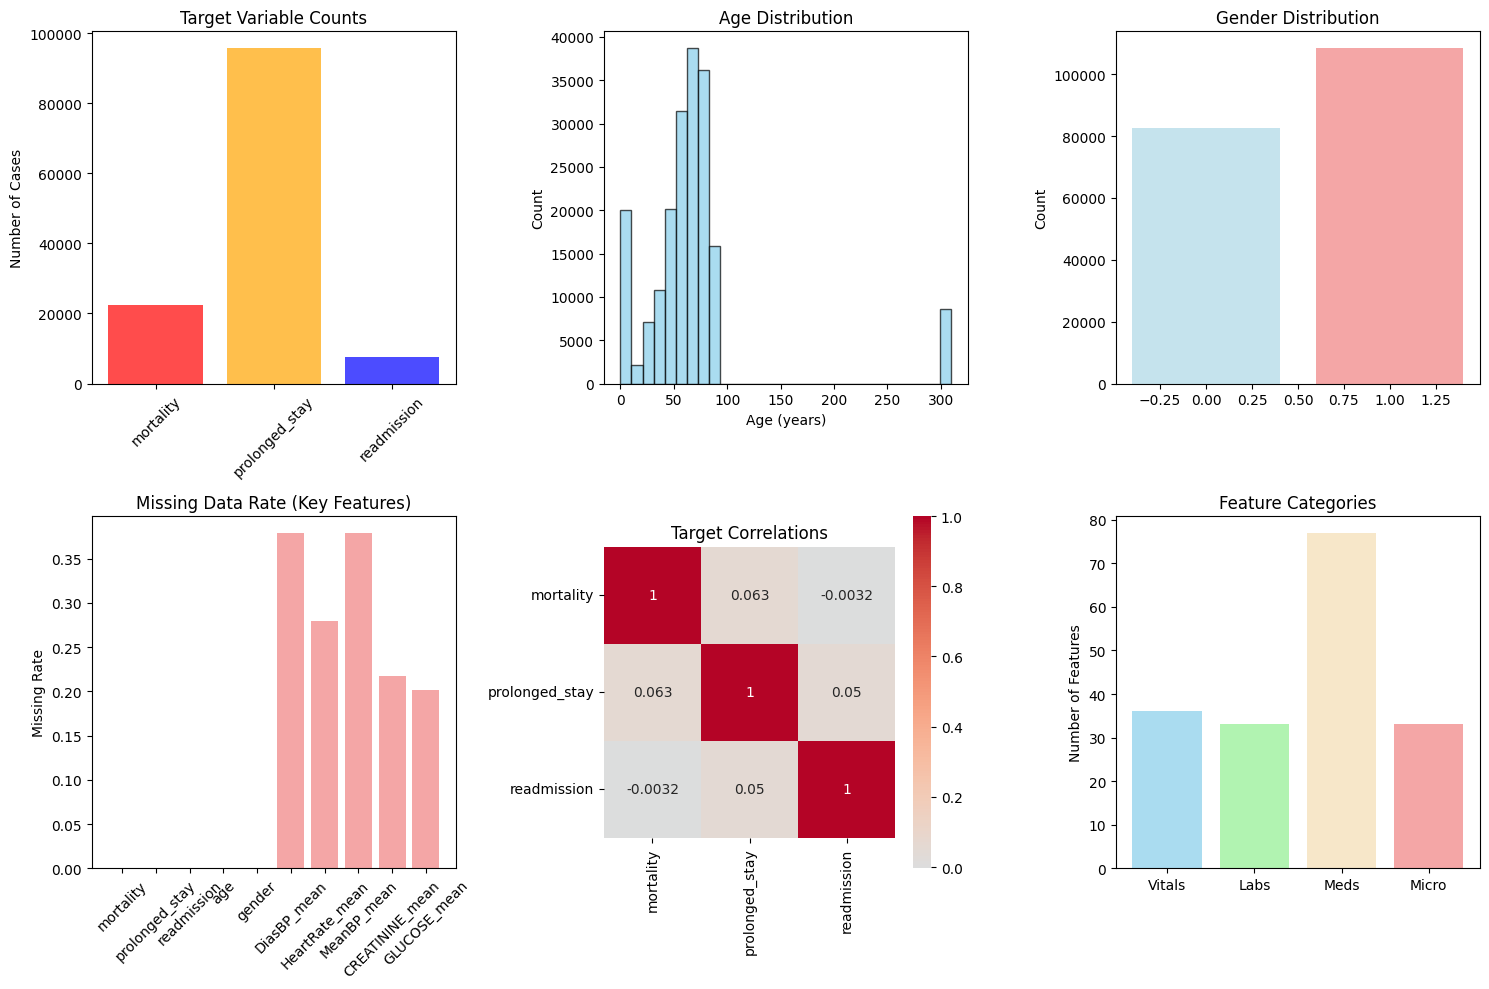

Visualizations created successfully!


In [16]:
# ============================================================================
# VISUALIZATIONS
# ============================================================================

print(f"\\n=== CREATING VISUALIZATIONS ===")

# Create basic visualizations if possible
try:
    plt.figure(figsize=(15, 10))

    # Target distributions
    plt.subplot(2, 3, 1)
    if target_cols:
        target_counts = [df[col].sum() for col in target_cols]
        plt.bar(target_cols, target_counts, color=['red', 'orange', 'blue'], alpha=0.7)
        plt.title('Target Variable Counts')
        plt.ylabel('Number of Cases')
        plt.xticks(rotation=45)

    # Age distribution if available
    plt.subplot(2, 3, 2)
    if 'age' in df.columns:
        plt.hist(df['age'].dropna(), bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        plt.title('Age Distribution')
        plt.xlabel('Age (years)')
        plt.ylabel('Count')

    # Gender distribution if available
    plt.subplot(2, 3, 3)
    if 'gender' in df.columns:
        gender_counts = df['gender'].value_counts()
        plt.bar(gender_counts.index, gender_counts.values, color=['lightcoral', 'lightblue'], alpha=0.7)
        plt.title('Gender Distribution')
        plt.ylabel('Count')

    # Missing data heatmap for key columns
    plt.subplot(2, 3, 4)
    key_cols = target_cols + ['age', 'gender'] + vital_features[:3] + lab_features[:3]
    key_cols = [col for col in key_cols if col in df.columns][:10]  # Top 10 key columns
    if key_cols:
        missing_data = df[key_cols].isnull().mean()
        plt.bar(range(len(missing_data)), missing_data.values, color='lightcoral', alpha=0.7)
        plt.title('Missing Data Rate (Key Features)')
        plt.ylabel('Missing Rate')
        plt.xticks(range(len(missing_data)), missing_data.index, rotation=45)

    # Target correlation heatmap
    plt.subplot(2, 3, 5)
    if len(target_cols) > 1:
        sns.heatmap(df[target_cols].corr(), annot=True, cmap='coolwarm', center=0, square=True)
        plt.title('Target Correlations')

    # Feature category counts
    plt.subplot(2, 3, 6)
    feature_counts = [len(vital_features), len(lab_features), len(med_features), len(micro_features)]
    feature_names = ['Vitals', 'Labs', 'Meds', 'Micro']
    plt.bar(feature_names, feature_counts, color=['skyblue', 'lightgreen', 'wheat', 'lightcoral'], alpha=0.7)
    plt.title('Feature Categories')
    plt.ylabel('Number of Features')

    plt.tight_layout()
    plt.show()

    print("Visualizations created successfully!")

except ImportError:
    print("Matplotlib not available for visualizations")
except Exception as e:
    print(f"Error creating visualizations: {e}")

In [17]:
# ============================================================================
# FINAL SUMMARY
# ============================================================================

print(f"\\n" + "="*80)
print("EXPLORATORY DATA ANALYSIS SUMMARY")
print("="*80)

print(f"📊 Dataset Overview:")
print(f"   • {df.shape[0]:,} total observations")
print(f"   • {df['subject_id'].nunique():,} unique patients")
print(f"   • {df.shape[1]} total features")
print(f"   • {df.groupby('subject_id').size().mean():.1f} avg time periods per patient")

print(f"\\n🎯 Target Variables:")
for target in target_cols:
    if target in df.columns:
        count = df[target].sum()
        rate = df[target].mean()
        print(f"   • {target}: {count:,} cases ({rate:.1%} prevalence)")

print(f"\\n📈 Feature Categories:")
print(f"   • Vital signs: {len(vital_features)} features")
print(f"   • Laboratory: {len(lab_features)} features")
print(f"   • Medications: {len(med_features)} features")
print(f"   • Microbiology: {len(micro_features)} features")

print(f"\\n💾 Data Quality:")
overall_missing = df.isnull().mean().mean()
print(f"   • Overall missing rate: {overall_missing:.1%}")
complete_cases = df.dropna().shape[0]
print(f"   • Complete cases: {complete_cases:,} ({complete_cases/len(df):.1%})")

print(f"\\n✅ Status: Dataset ready for modeling!")
print(f"   • All targets pre-computed")
print(f"   • Advanced feature engineering completed")
print(f"   • Multi-modal clinical data integrated")
print(f"   • Temporal aggregation applied (6h windows)")

print("="*80)
print("💡 Next Steps: Data partitioning → Feature selection → Model training")
print("="*80)

\n================================================================================
EXPLORATORY DATA ANALYSIS SUMMARY
📊 Dataset Overview:
   • 190,963 total observations
   • 27,636 unique patients
   • 274 total features
   • 6.9 avg time periods per patient
\n🎯 Target Variables:
   • mortality: 22,289 cases (11.7% prevalence)
   • prolonged_stay: 95,800 cases (50.2% prevalence)
   • readmission: 7,503 cases (3.9% prevalence)
\n📈 Feature Categories:
   • Vital signs: 36 features
   • Laboratory: 33 features
   • Medications: 77 features
   • Microbiology: 33 features
\n💾 Data Quality:
   • Overall missing rate: 27.5%
   • Complete cases: 0 (0.0%)
\n✅ Status: Dataset ready for modeling!
   • All targets pre-computed
   • Advanced feature engineering completed
   • Multi-modal clinical data integrated
   • Temporal aggregation applied (6h windows)
💡 Next Steps: Data partitioning → Feature selection → Model training
